In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

In [31]:
def bootstrapping(y_true, y_pred, n=1000):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n_samples = len(y_true)

    results = {
        "MSE": {
            "value": mean_squared_error(y_true, y_pred),
            "CI": None
        },
        "RMSE": {
            "value": root_mean_squared_error(y_true, y_pred),
            "CI": None
        },
        "R2": {
            "value": r2_score(y_true, y_pred),
            "CI": None
        },
    }

    metrics = {
        "MSE": [],
        "RMSE": [],
        "R2": [],
    }

    for _ in range(n):
        indices = np.random.choice(np.arange(n_samples), size=n_samples, replace=True)
        y_true_bs = y_true[indices]
        y_pred_bs = y_pred[indices]

        metrics["MSE"].append(mean_squared_error(y_true_bs, y_pred_bs))
        metrics["RMSE"].append(root_mean_squared_error(y_true_bs, y_pred_bs))
        metrics["R2"].append(r2_score(y_true_bs, y_pred_bs))

    for metric, values in metrics.items():
        se = np.std(values) / np.sqrt(n)
        results[metric]["CI"] = se * 1.96

    return results

In [32]:
baseline_mean = pd.read_csv("baseline_mean.csv")
baseline_linreg = pd.read_csv("baseline_linreg.csv")
model_gam = pd.read_csv("gam.csv")
model_mlp = pd.read_csv("mlp.csv")

dataframes = {
    "baseline_mean": baseline_mean,
    "baseline_linreg": baseline_linreg,
    "model_gam": model_gam,
    "model_mlp": model_mlp,
}

all_results = []

for method_name, df in dataframes.items():
    columns = df.columns
    metric_pairs = {}
    for col in columns:
        if col.endswith("-true"):
            base_name = col.rsplit("-", 1)[0]
            pred_name = base_name + "-pred"
            if pred_name in columns:
                metric_pairs[base_name] = (col, pred_name)
    
    for base_name, (true_col, pred_col) in metric_pairs.items():
        res = bootstrapping(df[true_col], df[pred_col])
        # Flatten results for final DataFrame
        result_dict = {
            "Method": method_name,
            "Metric_Base": base_name,
            "MSE_value": res["MSE"]["value"],
            "MSE_CI": res["MSE"]["CI"],
            "RMSE_value": res["RMSE"]["value"],
            "RMSE_CI": res["RMSE"]["CI"],
            "R2_value": res["R2"]["value"],
            "R2_CI": res["R2"]["CI"]
        }
        all_results.append(result_dict)

In [33]:
final_df = pd.DataFrame(all_results)
final_df

,Method,Metric_Base,MSE_value,MSE_CI,RMSE_value,RMSE_CI,R2_value,R2_CI
0,baseline_mean,pear_corr_min_max,0.005565,0.000040,0.074598,0.000268,-2.883419e-04,0.000122
1,baseline_mean,pear_corr_sigmoid,0.006010,0.000026,0.077524,0.000165,-6.634786e-05,0.000082
2,baseline_mean,cos_sim_min_max,0.008925,0.000023,0.094471,0.000122,-2.026547e-04,0.000098
3,baseline_mean,cos_sim_sigmoid,0.009168,0.000024,0.095750,0.000126,-4.714731e-07,0.000083
4,baseline_linreg,raw-pear_corr_min_max,0.001534,0.000012,0.039162,0.000154,7.243187e-01,0.001901
5,baseline_linreg,raw-pear_corr_sigmoid,0.001508,0.000012,0.038834,0.000147,7.490472e-01,0.001423
6,baseline_linreg,raw-cos_sim_min_max,0.002753,0.000008,0.052464,0.000077,6.915267e-01,0.001021
7,baseline_linreg,raw-cos_sim_sigmoid,0.000417,0.000001,0.020422,0.000033,9.545087e-01,0.000170
8,baseline_linreg,pca-pear_corr_min_max,0.002251,0.000015,0.047448,0.000155,5.953151e-01,0.002107
9,baseline_linreg,pca-pear_corr_sigmoid,0.002443,0.000017,0.049430,0.000169,5.934245e-01,0.001583


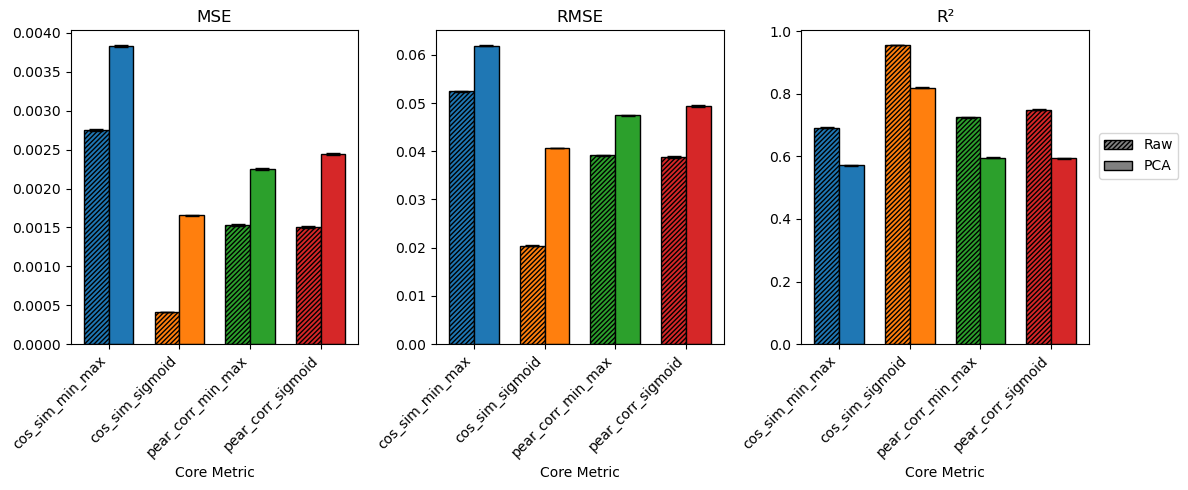

In [34]:
# Plot baseline regression for PCA and raw data
plot_df = final_df[final_df["Method"] == "baseline_linreg"].copy()
plot_df["Data_Type"] = plot_df["Metric_Base"].apply(lambda x: "raw" if x.startswith("raw-") else "pca")
plot_df["Core_Metric"] = plot_df["Metric_Base"].apply(lambda x: x.replace("raw-", "").replace("pca-", ""))

core_metrics = plot_df["Core_Metric"].unique()
core_metrics = sorted(core_metrics)

metrics_to_plot = [("MSE_value", "MSE_CI", "MSE"),
                   ("RMSE_value", "RMSE_CI", "RMSE"),
                   ("R2_value", "R2_CI", "R²")
                   ]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

cmap = plt.get_cmap("tab10")
colors = {m: cmap(i) for i, m in enumerate(core_metrics)}

bar_width = 0.35
x = np.arange(len(core_metrics))  # positions for the groups

for ax, (val_col, ci_col, title) in zip(axes, metrics_to_plot):
    for i, core in enumerate(core_metrics):
        # Get data for this core metric
        df_core = plot_df[plot_df["Core_Metric"] == core]

        # raw data row
        raw_row = df_core[df_core["Data_Type"] == "raw"].iloc[0]
        # pca data row
        pca_row = df_core[df_core["Data_Type"] == "pca"].iloc[0]

        # Plot raw bar
        ax.bar(x[i] - bar_width/2, raw_row[val_col], yerr=raw_row[ci_col],
               width=bar_width, color=colors[core], hatch="///////",
               capsize=5, edgecolor='black')
        
        # Plot pca bar
        ax.bar(x[i] + bar_width/2, pca_row[val_col], yerr=pca_row[ci_col],
               width=bar_width, color=colors[core], capsize=5, edgecolor='black')

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(core_metrics, rotation=45, ha='right')
    ax.set_xlabel("Core Metric")

# Add a legend explaining raw vs pca

legend_patches = [
    Patch(facecolor='gray', edgecolor='black', hatch='///////', label='Raw'),
    Patch(facecolor='gray', edgecolor='black', label='PCA')
]

axes[2].legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.01, 0.6))

plt.tight_layout()
plt.show()

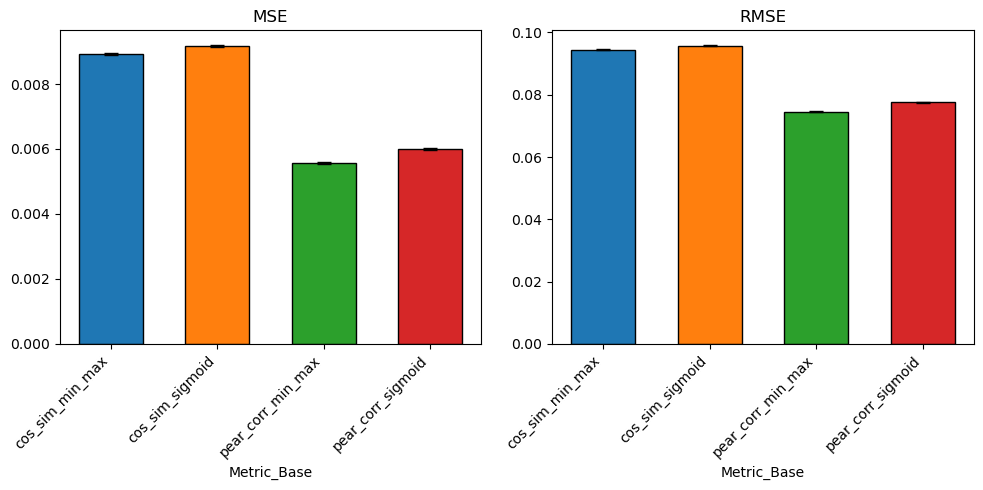

In [35]:
plot_df_mean = final_df[final_df["Method"] == "baseline_mean"].copy()

# Extract the metrics
metrics_base = plot_df_mean["Metric_Base"].unique()
metrics_base = sorted(metrics_base)  # sort for consistent ordering

# We'll plot three subplots: MSE, RMSE, R2
metrics_to_plot = [("MSE_value", "MSE_CI", "MSE"),
                   ("RMSE_value", "RMSE_CI", "RMSE")]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Use the same color scheme as before
cmap = plt.get_cmap("tab10")
colors = {m: cmap(i) for i, m in enumerate(metrics_base)}

x = np.arange(len(metrics_base))  # positions for the bars
bar_width = 0.6

for ax, (val_col, ci_col, title) in zip(axes, metrics_to_plot):
    for i, base in enumerate(metrics_base):
        row = plot_df_mean[plot_df_mean["Metric_Base"] == base].iloc[0]
        
        ax.bar(x[i], row[val_col], yerr=row[ci_col], width=bar_width,
               color=colors[base], edgecolor='black', capsize=5)
    
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_base, rotation=45, ha='right')
    ax.set_xlabel("Metric_Base")

plt.tight_layout()
plt.show()

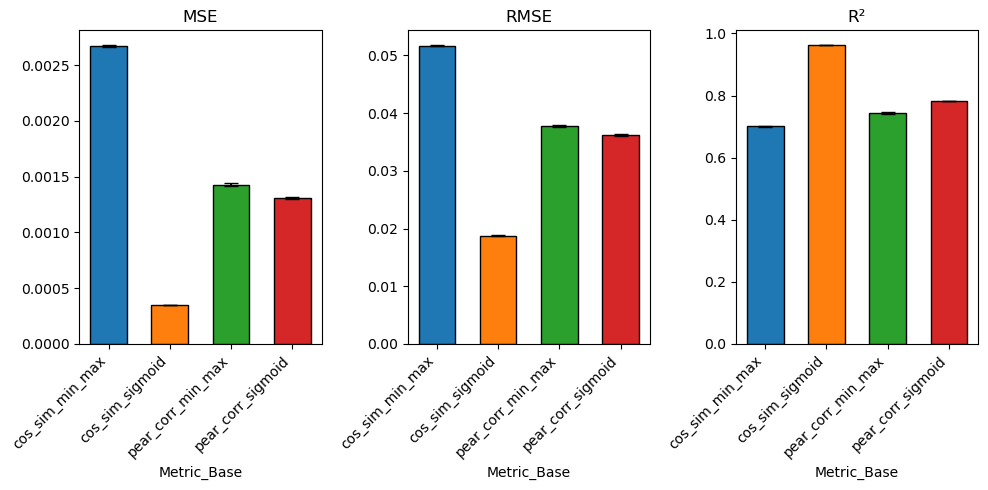

In [36]:
plot_df_mlp = final_df[final_df["Method"] == "model_mlp"].copy()

# Extract the metrics
metrics_base = plot_df_mlp["Metric_Base"].unique()
metrics_base = sorted(metrics_base)  # sort for consistency

# We'll plot three subplots: MSE, RMSE, R2
metrics_to_plot = [("MSE_value", "MSE_CI", "MSE"),
                   ("RMSE_value", "RMSE_CI", "RMSE"),
                   ("R2_value", "R2_CI", "R²")]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

cmap = plt.get_cmap("tab10")
colors = {m: cmap(i) for i, m in enumerate(metrics_base)}

x = np.arange(len(metrics_base))
bar_width = 0.6

for ax, (val_col, ci_col, title) in zip(axes, metrics_to_plot):
    for i, base in enumerate(metrics_base):
        row = plot_df_mlp[plot_df_mlp["Metric_Base"] == base].iloc[0]
        
        ax.bar(x[i], row[val_col], yerr=row[ci_col], width=bar_width,
               color=colors[base], edgecolor='black', capsize=5)
    
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_base, rotation=45, ha='right')
    ax.set_xlabel("Metric_Base")

plt.tight_layout()
plt.show()

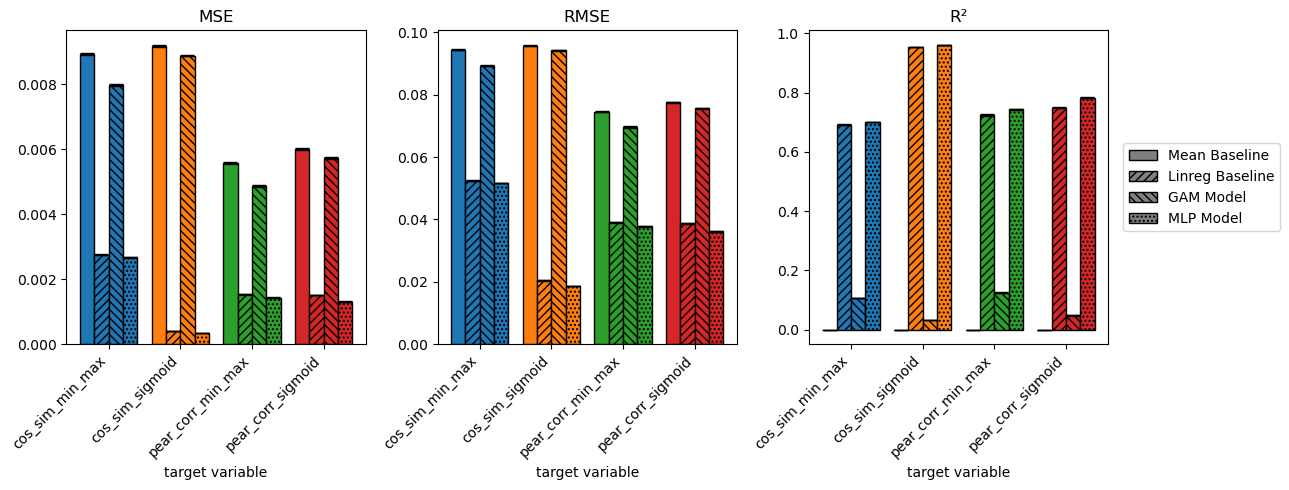

In [41]:
# Filter data for each method
plot_df_mean = final_df[final_df["Method"] == "baseline_mean"].copy()
plot_df_linreg = final_df[final_df["Method"] == "baseline_linreg"].copy()
plot_df_gam = final_df[final_df["Method"] == "model_gam"].copy()
plot_df_mlp = final_df[final_df["Method"] == "model_mlp"].copy()

# Remove PCA metrics from linreg
plot_df_linreg = plot_df_linreg[~plot_df_linreg["Metric_Base"].str.startswith("pca-")]

# Linreg still has a "raw-" prefix, remove it to match the naming scheme of the others
plot_df_linreg["Metric_Base"] = plot_df_linreg["Metric_Base"].str.replace("^raw-", "", regex=True)

# Now all three dataframes should have consistent metric names without prefixes.
metrics_mean = set(plot_df_mean["Metric_Base"].unique())
metrics_linreg = set(plot_df_linreg["Metric_Base"].unique())
metrics_gam = set(plot_df_gam["Metric_Base"].unique())
metrics_mlp = set(plot_df_mlp["Metric_Base"].unique())

common_metrics = sorted(metrics_mean & metrics_linreg & metrics_gam & metrics_mlp)

# We expect four distinct metrics in common_metrics
metrics_to_plot = [("MSE_value", "MSE_CI", "MSE"),
                   ("RMSE_value", "RMSE_CI", "RMSE"),
                   ("R2_value", "R2_CI", "R²")]

fig, axes = plt.subplots(1, 3, figsize=(13, 5))

x = np.arange(len(common_metrics))
bar_width = 0.20

cmap = plt.get_cmap("tab10")
colors = {m: cmap(i) for i, m in enumerate(common_metrics)}

# Define hatching patterns for each method:
# - Mean baseline: no hatch
# - Linreg baseline: '////'
# - MLP model: '....'
hatch_mean = ""
hatch_linreg = "////"
hatch_gam = "\\\\\\\\"
hatch_mlp = "...."

for ax, (val_col, ci_col, title) in zip(axes, metrics_to_plot):
    for i, metric in enumerate(common_metrics):
        # Extract rows for each method & metric
        mean_row = plot_df_mean[plot_df_mean["Metric_Base"] == metric].iloc[0]
        linreg_row = plot_df_linreg[plot_df_linreg["Metric_Base"] == metric].iloc[0]
        gam_row = plot_df_gam[plot_df_gam["Metric_Base"] == metric].iloc[0]
        mlp_row = plot_df_mlp[plot_df_mlp["Metric_Base"] == metric].iloc[0]

        # Mean baseline bar
        ax.bar(x[i] - 1.5 * bar_width, mean_row[val_col], yerr=mean_row[ci_col],
               width=bar_width, color=colors[metric], edgecolor='black',
               capsize=5, hatch=hatch_mean)

        # Linreg baseline bar
        ax.bar(x[i] - 0.5 * bar_width, linreg_row[val_col], yerr=linreg_row[ci_col],
               width=bar_width, color=colors[metric], edgecolor='black',
               capsize=5, hatch=hatch_linreg)
        
        # Model gam bar
        ax.bar(x[i] + 0.5 * bar_width, gam_row[val_col], yerr=gam_row[ci_col],
               width=bar_width, color=colors[metric], edgecolor='black',
               capsize=5, hatch=hatch_gam)

        # MLP model bar
        ax.bar(x[i] + 1.5 * bar_width, mlp_row[val_col], yerr=mlp_row[ci_col],
               width=bar_width, color=colors[metric], edgecolor='black',
               capsize=5, hatch=hatch_mlp)

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(common_metrics, rotation=45, ha='right')
    ax.set_xlabel("target variable")

# Legend to the right
legend_patches = [
    Patch(facecolor='gray', edgecolor='black', hatch=hatch_mean, label='Mean Baseline'),
    Patch(facecolor='gray', edgecolor='black', hatch=hatch_linreg, label='Linreg Baseline'),
    Patch(facecolor='gray', edgecolor='black', hatch=hatch_gam, label='GAM Model'),
    Patch(facecolor='gray', edgecolor='black', hatch=hatch_mlp, label='MLP Model')
]

plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

plt.tight_layout()
plt.show()